In [130]:
!pip install ta

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import ta
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
from sklearn.linear_model import LinearRegression

rcParams['figure.figsize']=(12,6)

In [131]:
df = yf.download('OJ=F')
orange_df = df.copy()

[*********************100%***********************]  1 of 1 completed


In [132]:
orange_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [133]:
orange_df = orange_df[['Adj Close']]
orange_df.columns=['close']
orange_df.head()

,close
Date,
2021-09-07,147.000000
2021-09-08,143.100006
2021-09-09,144.250000
2021-09-10,147.100006
2021-09-13,142.100006


In [134]:
orange_df['SMA 15'] = orange_df.close.rolling(15).mean().shift(1)
orange_df['SMA 60'] = orange_df.close.rolling(60).mean().shift(1)
#Скользящее среднее

<Axes: xlabel='Date'>

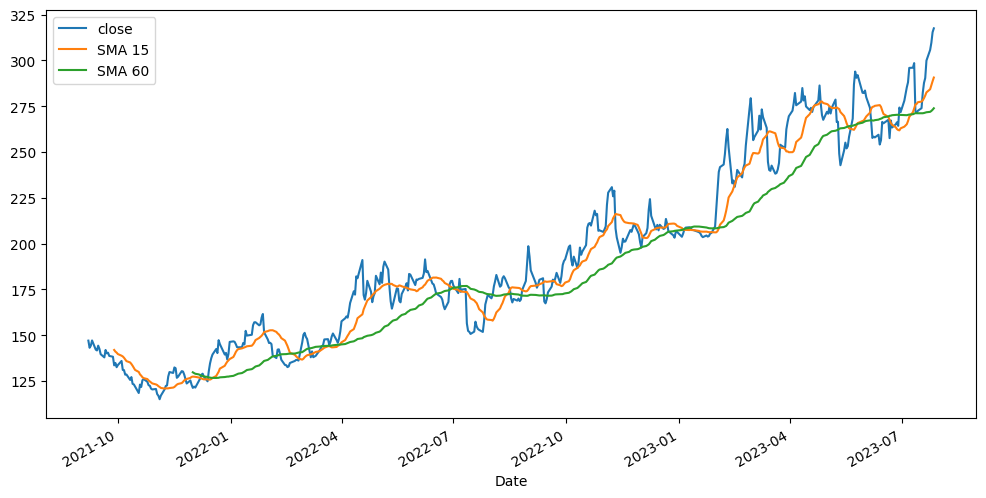

In [135]:
orange_df.plot()

In [136]:
orange_df['returns'] = orange_df.close.pct_change(1)
orange_df['MSD 15'] = orange_df.returns.rolling(15).std().shift(1)
orange_df['MSD 60'] = orange_df.returns.rolling(60).std().shift(1)

<Axes: xlabel='Date'>

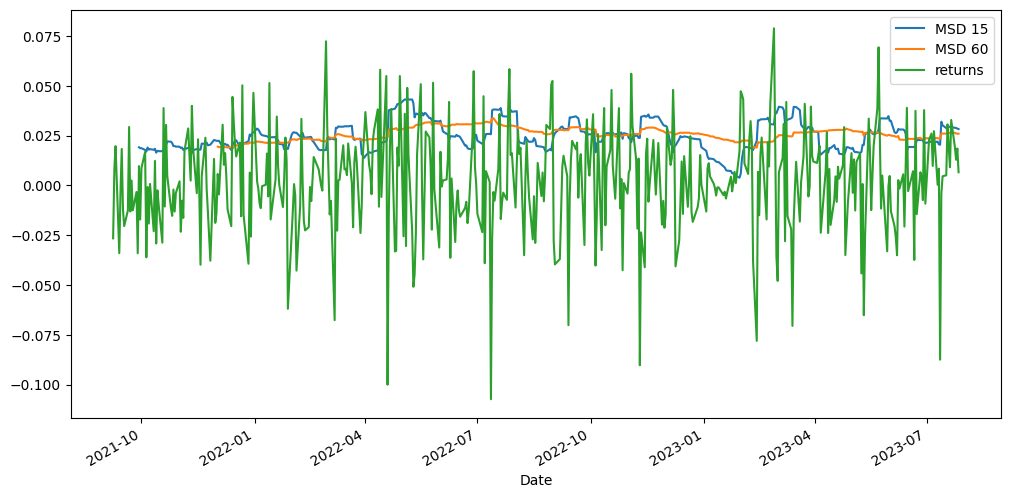

In [137]:
orange_df[['MSD 15', 'MSD 60', 'returns']].plot()

In [138]:
RSI = ta.momentum.RSIIndicator(orange_df.close)

In [139]:
orange_df['RSI'] = RSI.rsi()

<Axes: xlabel='Date'>

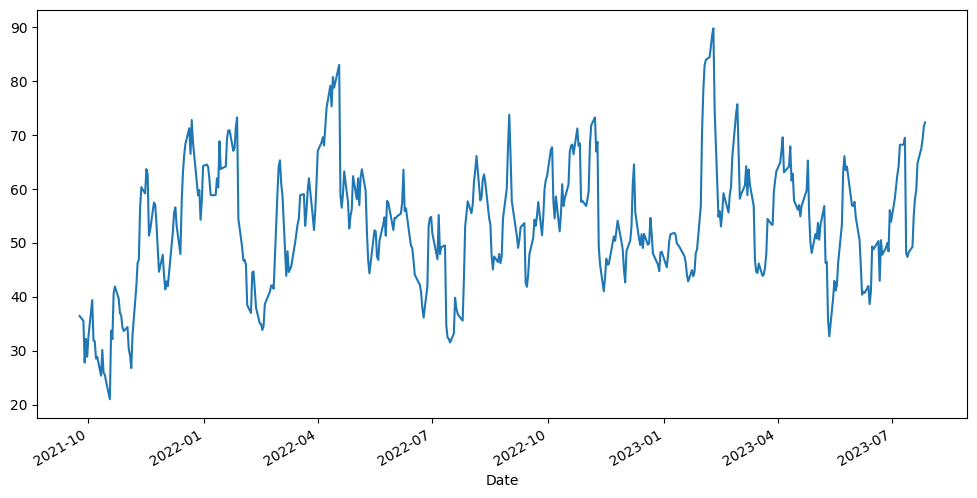

In [140]:
orange_df.RSI.plot()

# Linear Regression

In [141]:
orange_df.head(5)

,close,SMA 15,SMA 60,returns,MSD 15,MSD 60,RSI
Date,,,,,,,
2021-09-07,147.000000,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-08,143.100006,NaN,NaN,-0.026531,NaN,NaN,NaN
2021-09-09,144.250000,NaN,NaN,0.008036,NaN,NaN,NaN
2021-09-10,147.100006,NaN,NaN,0.019757,NaN,NaN,NaN
2021-09-13,142.100006,NaN,NaN,-0.033990,NaN,NaN,NaN


In [151]:
orange_df = orange_df.iloc[62:]

In [152]:
train_size = int(df.shape[0]*0.75)
X_tr, X_ts = orange_df[['SMA 15',	'SMA 60', 'MSD 15',	'MSD 60',	'RSI']].iloc[:train_size], orange_df[['SMA 15',	'SMA 60', 'MSD 15',	'MSD 60',	'RSI']].iloc[train_size:]
y_tr, y_ts = orange_df[['returns']].iloc[:train_size], orange_df[['returns']].iloc[train_size:]
X_tr.shape, X_ts.shape

((356, 5), (57, 5))

In [153]:
lr = LinearRegression()
lr.fit(X_tr, y_tr)

LinearRegression()

In [154]:
X = pd.concat([X_tr, X_ts], axis=0)

In [155]:
orange_df['prediction'] = lr.predict(X)

<Axes: xlabel='Date'>

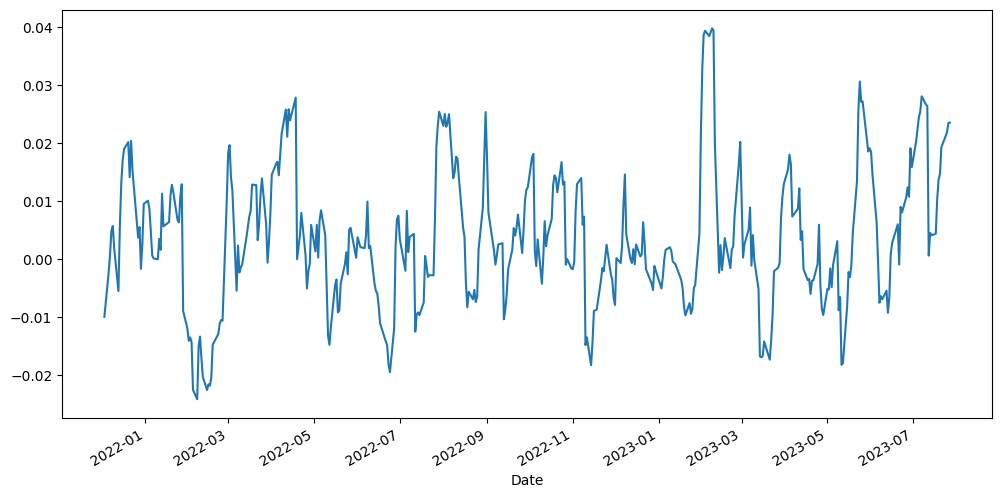

In [156]:
orange_df['prediction'].plot()

<Axes: xlabel='Date'>

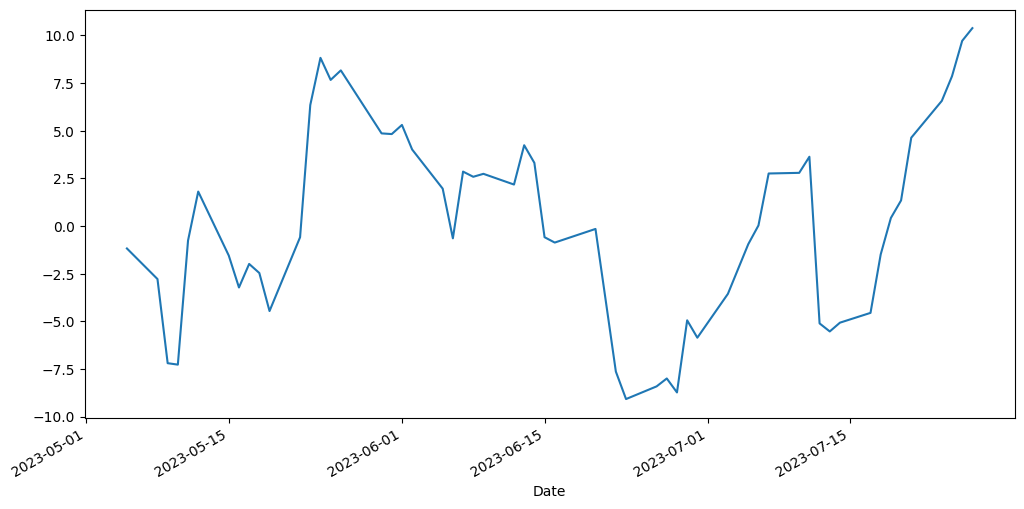

In [158]:
orange_df['position'] = np.sign(orange_df.prediction)
orange_df['strategy'] = orange_df.returns * orange_df.position.shift(1)
(orange_df.strategy.iloc[train_size:].cumsum()*100).plot()

# RNN

In [ ]:
df = df.reset_index()

In [ ]:
df.shape

(475, 7)

In [ ]:
df.corr()

<ipython-input-77-2f6f6606aa2c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.998247,0.998503,0.996725,0.996725,-0.136004
High,0.998247,1.000000,0.997981,0.998764,0.998764,-0.113634
Low,0.998503,0.997981,1.000000,0.998366,0.998366,-0.148099
Close,0.996725,0.998764,0.998366,1.000000,1.000000,-0.127547
Adj Close,0.996725,0.998764,0.998366,1.000000,1.000000,-0.127547
Volume,-0.136004,-0.113634,-0.148099,-0.127547,-0.127547,1.000000


In [ ]:
train = int(df.shape[0]*0.75)
X_train, X_test = df.iloc[:train], df.iloc[train:]
X_train.shape, X_test.shape

((356, 7), (119, 7))

In [ ]:
X_train

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-09-07,147.000000,147.000000,147.000000,147.000000,147.000000,0
1,2021-09-08,145.550003,145.550003,144.000000,143.100006,143.100006,4
2,2021-09-09,144.250000,144.250000,144.250000,144.250000,144.250000,0
3,2021-09-10,147.100006,147.100006,147.100006,147.100006,147.100006,462
4,2021-09-13,141.649994,142.699997,140.899994,142.100006,142.100006,349
...,...,...,...,...,...,...,...
351,2023-01-30,205.850006,211.399994,205.750000,209.300003,209.300003,940
352,2023-01-31,209.449997,219.300003,209.000000,219.199997,219.199997,1609
353,2023-02-01,220.500000,229.199997,220.500000,229.199997,229.199997,2235
354,2023-02-02,230.550003,244.750000,230.550003,239.100006,239.100006,2353


In [ ]:
sc = StandardScaler()
sc.fit(X_train[['Low']])

StandardScaler()

In [ ]:
def make_dataset(df, window_size, batch_size, use_scaler=True, shuffle=True):
  features = df[['Low']].iloc[:-window_size]
  if use_scaler:
    features = sc.transform(features)
  data = np.array(features, dtype=np.float32)
  ds = tf.keras.preprocessing. timeseries_dataset_from_array(data=data, targets=df['Low'].iloc[window_size:], sequence_length = window_size, sequence_stride=1, shuffle=shuffle, batch_size=batch_size)
  return ds

In [ ]:
window_size = 10
batch_size=  5

X_tr_ds = make_dataset(df=X_train, window_size=window_size, batch_size=batch_size)
X_ts_ds = make_dataset(df=X_test, window_size=window_size, batch_size=batch_size)

In [ ]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(1)
])

In [ ]:
def compile_fit(model, X_train, X_test, num_epochs: int=20):
  model.compile(
      loss=tf.losses.MeanSquaredError(),
      optimizer=tf.optimizers.Adam(),
      metrics=[tf.metrics.MeanAbsoluteError()]
  )
  history = model.fit(
      X_train, epochs=num_epochs,
      validation_data=X_test,\
      verbose=0
  )
  return history

In [ ]:
history = compile_fit(lstm_model, X_tr_ds, X_ts_ds, num_epochs=100)

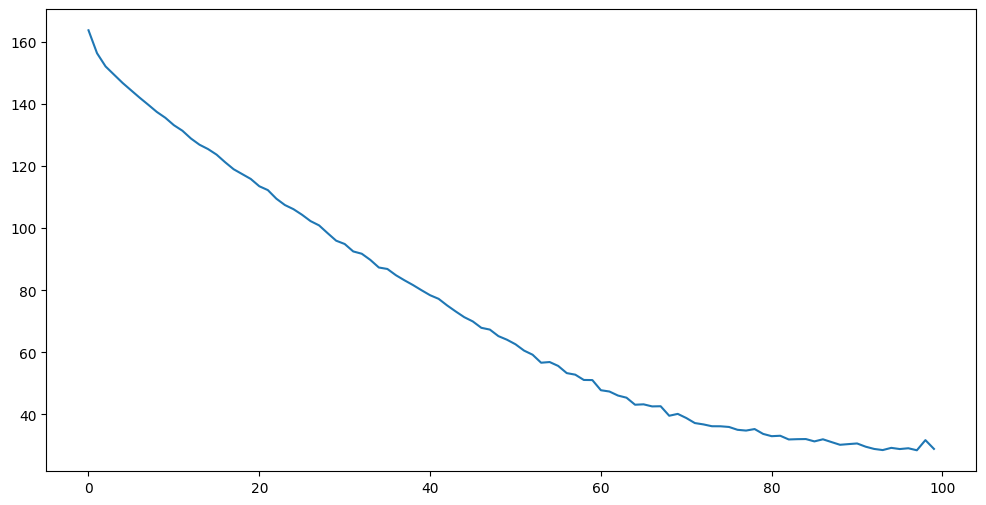

In [ ]:
plt.plot(history.history['mean_absolute_error'])

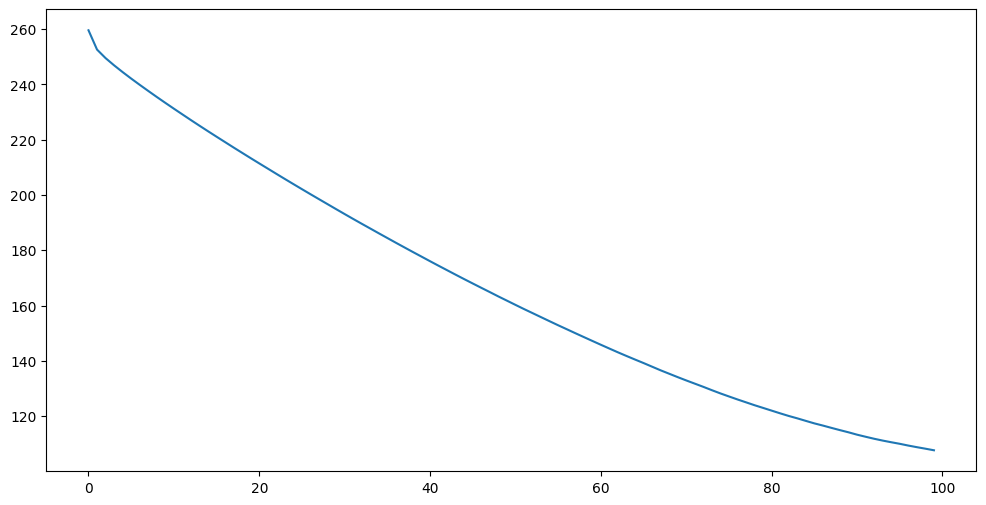

In [ ]:
plt.plot(history.history['val_mean_absolute_error'])

In [ ]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1)
])

history = compile_fit(lstm_model, X_tr_ds, X_ts_ds, num_epochs=100)

In [ ]:
lstm_model.evaluate(X_tr_ds)

68/68 [==============================] - 0s 3ms/step - loss: 735.3057 - mean_absolute_error: 22.3475


[735.3056640625, 22.34746742248535]

In [ ]:
lstm_model.evaluate(X_ts_ds)

20/20 [==============================] - 0s 4ms/step - loss: 11175.4297 - mean_absolute_error: 104.6505


[11175.4296875, 104.65052795410156]